###### [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/adaptive-intelligent-robotics/QDax/blob/main/notebooks/cmamega_example.ipynb)

# Optimizing with CMA-ME in Jax

This notebook shows how to use QDax to find diverse and performing parameters on the Rastrigin problem with [CMA-MEGA](https://arxiv.org/pdf/2106.03894.pdf). It can be run locally or on Google Colab. We recommand to use a GPU. This notebook will show:

- how to define the problem
- how to create a cma-mega emitter
- how to create a Map-elites instance
- which functions must be defined before training
- how to launch a certain number of training steps
- how to visualise the optimization process

In [16]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
import math

import jax 
import jax.numpy as jnp

try:
    import flax
except:
    !pip install --no-deps git+https://github.com/google/flax.git@v0.4.1 |tail -n 1
    import flax

try:
    import chex
except:
    !pip install --no-deps git+https://github.com/deepmind/chex.git@v0.1.3 |tail -n 1
    import chex
    
try:
    import qdax
except:
    !pip install --no-deps git+https://github.com/adaptive-intelligent-robotics/QDax@main |tail -n 1
    import qdax

from qdax.core.map_elites import MAPElites
from qdax.core.emitters.cma_emitter import CMAEmitter
from qdax.core.emitters.cma_opt_emitter import CMAOptimizingEmitter
from qdax.core.emitters.cma_rnd_emitter import CMARndEmitter
from qdax.core.emitters.cma_multi_emitter import CMAMultiEmitter
from qdax.core.emitters.standard_emitters import MixingEmitter
from qdax.core.containers.mapelites_repertoire import compute_euclidean_centroids, MapElitesRepertoire
# from qdax.utils.plotting import plot_map_elites_results
from qdax.utils.plotting import plot_multidimensional_map_elites_grid

from typing import Dict

In [18]:
# from jax.config import config

# config.update('jax_disable_jit', True)

## Set the hyperparameters

Most hyperparameters are similar to those introduced in [Differentiable Quality Diversity paper](https://arxiv.org/pdf/2106.03894.pdf).

In [108]:
#@title QD Training Definitions Fields
#@markdown ---
num_iterations = 70000 #70000 #10000
num_dimensions = 100 #1000 #@param {type:"integer"} # try 20 and 100
# num_centroids = 10000 #@param {type:"integer"}
grid_shape = (500, 500) # (500, 500) 
batch_size = 500 #36 #@param {type:"integer"}
sigma_g = .5 #@param {type:"number"}
minval = -5.12 #@param {type:"number"}
maxval = 5.12 #@param {type:"number"}
min_bd = -5.12 * 0.5 * num_dimensions #@param {type:"number"}
max_bd = 5.12 * 0.5 * num_dimensions #@param {type:"number"}
#@markdown ---

## Defines the scoring function: rastrigin

As we are in the Differentiable QD setting, the scoring function does not only retrieve the fitness and descriptors, but also the gradients.

In [109]:
def rastrigin_scoring(x: jnp.ndarray):
    first_term = 10 * x.shape[-1]
    second_term = jnp.sum((x + minval * 0.4) ** 2 - 10 * jnp.cos(2 * jnp.pi * (x + minval * 0.4)))
    return -(first_term + second_term)

def clip(x: jnp.ndarray):
    in_bound = (x <= maxval) * (x >= minval)
    return jnp.where(
        condition=in_bound,
        x=x,
        y=(maxval / x)
    )

def _rastrigin_descriptor_1(x: jnp.ndarray):
    return jnp.sum(clip(x[:x.shape[-1]//2]))

def _rastrigin_descriptor_2(x: jnp.ndarray):
    return jnp.sum(clip(x[x.shape[-1]//2:]))

def rastrigin_descriptors(x: jnp.ndarray):
    return jnp.array([_rastrigin_descriptor_1(x), _rastrigin_descriptor_2(x)])

In [110]:
def scoring_function(x):
    scores, descriptors = rastrigin_scoring(x), rastrigin_descriptors(x)
    return scores, descriptors, {}

def scoring_fn(x, random_key):
    fitnesses, descriptors, extra_scores = jax.vmap(scoring_function)(x)
    return fitnesses, descriptors, extra_scores, random_key

## Define the metrics that will be used

In [111]:
worst_objective = rastrigin_scoring(-jnp.ones(num_dimensions) * 5.12)
# worst_objective = rastrigin_scoring(jnp.zeros(num_dimensions))
best_objective = rastrigin_scoring(jnp.ones(num_dimensions) * 5.12 * 0.4)

num_centroids = math.prod(grid_shape)

def metrics_fn(repertoire: MapElitesRepertoire) -> Dict[str, jnp.ndarray]:

    # get metrics
    grid_empty = repertoire.fitnesses == -jnp.inf
    adjusted_fitness = (
        (repertoire.fitnesses - worst_objective) * 100 / (best_objective - worst_objective)
    )
    qd_score = jnp.sum(adjusted_fitness, where=~grid_empty) # / num_centroids
    coverage = 100 * jnp.mean(1.0 - grid_empty)
    max_fitness = jnp.max(adjusted_fitness)
    return {"qd_score": qd_score, "max_fitness": max_fitness, "coverage": coverage}

## Define the initial population, the emitter and the MAP Elites instance

The emitter is defined using the CMAME emitter class. This emitter is given to a MAP-Elites instance to create an instance of the CMA-ME algorithm.

In [112]:
random_key = jax.random.PRNGKey(0)
initial_population = jax.random.uniform(random_key, shape=(batch_size, num_dimensions))

centroids = compute_euclidean_centroids(
    grid_shape=grid_shape,
    minval=min_bd,
    maxval=max_bd,
)

# Define emitter
import functools
from qdax.core.emitters.mutation_operators import isoline_variation
variation_fn = functools.partial(
    isoline_variation, iso_sigma=0.5, line_sigma=0.
)
mixing_emitter = MixingEmitter(
    mutation_fn=None, 
    variation_fn=variation_fn, 
    variation_percentage=1.0, 
    batch_size=batch_size
)

# emitter = CMAOptimizingEmitter(
# emitter = CMAEmitter(
emitter = CMARndEmitter(
    batch_size=batch_size,
    genotype_dim=num_dimensions,
    centroids=centroids,
    sigma_g=sigma_g,
    min_count=1
)

emitter = CMAMultiEmitter(
    num_states=15,
    emitter=emitter
)

map_elites = MAPElites(
    scoring_function=scoring_fn,
    emitter=emitter,
#     emitter=mixing_emitter,
    metrics_function=metrics_fn
)

c1:  0.00018976394
c cov:  0.047393117
Eigen decomposition delay:  10.50798
Initial cov:  [[0.5 0.  0.  ... 0.  0.  0. ]
 [0.  0.5 0.  ... 0.  0.  0. ]
 [0.  0.  0.5 ... 0.  0.  0. ]
 ...
 [0.  0.  0.  ... 0.5 0.  0. ]
 [0.  0.  0.  ... 0.  0.5 0. ]
 [0.  0.  0.  ... 0.  0.  0.5]]
Initial invsqrt cov:  [[1.4142135 0.        0.        ... 0.        0.        0.       ]
 [0.        1.4142135 0.        ... 0.        0.        0.       ]
 [0.        0.        1.4142135 ... 0.        0.        0.       ]
 ...
 [0.        0.        0.        ... 1.4142135 0.        0.       ]
 [0.        0.        0.        ... 0.        1.4142135 0.       ]
 [0.        0.        0.        ... 0.        0.        1.4142135]]


In [113]:
repertoire, emitter_state, random_key = map_elites.init(initial_population, centroids, random_key)

Inv sqrt cov before:  Traced<ShapedArray(float32[100,100])>with<DynamicJaxprTrace(level=1/5)>
Eigen condition's value:  Traced<ShapedArray(bool[])>with<DynamicJaxprTrace(level=1/5)>
Cov:  Traced<ShapedArray(float32[100,100])>with<DynamicJaxprTrace(level=2/5)>
eig:  Traced<ShapedArray(float32[100])>with<DynamicJaxprTrace(level=2/5)>
Inv sqrt cov after:  Traced<ShapedArray(float32[100,100])>with<DynamicJaxprTrace(level=1/5)>
tmp_1:  Traced<ShapedArray(bool[])>with<DynamicJaxprTrace(level=1/5)>


In [114]:
%%time

(repertoire, emitter_state, random_key,), metrics = jax.lax.scan(
    map_elites.scan_update,
    (repertoire, emitter_state, random_key),
    (),
    length=num_iterations,
)

Inv sqrt cov before:  Traced<ShapedArray(float32[100,100])>with<DynamicJaxprTrace(level=2/6)>
Eigen condition's value:  Traced<ShapedArray(bool[])>with<DynamicJaxprTrace(level=2/6)>
Cov:  Traced<ShapedArray(float32[100,100])>with<DynamicJaxprTrace(level=3/6)>
eig:  Traced<ShapedArray(float32[100])>with<DynamicJaxprTrace(level=3/6)>
Inv sqrt cov after:  Traced<ShapedArray(float32[100,100])>with<DynamicJaxprTrace(level=2/6)>
tmp_1:  Traced<ShapedArray(bool[])>with<DynamicJaxprTrace(level=2/6)>
CPU times: user 3min 25s, sys: 58.8 ms, total: 3min 25s
Wall time: 3min 22s


In [115]:
for k, v in metrics.items():
    print(f"{k} after {num_iterations * batch_size}: {v[-1]}")

coverage after 35000000: 40.0823974609375
max_fitness after 35000000: 95.39686584472656
qd_score after 35000000: 7548011.0


In [116]:
metrics

{'coverage': DeviceArray([ 0.1348  ,  0.1768  ,  0.2016  , ..., 40.082397, 40.082397,
              40.082397], dtype=float32),
 'max_fitness': DeviceArray([81.4349  , 81.4349  , 81.4349  , ..., 95.396866, 95.396866,
              95.396866], dtype=float32),
 'qd_score': DeviceArray([  25520.24 ,   33404.086,   38084.1  , ..., 7548011.   ,
              7548011.   , 7548011.   ], dtype=float32)}

In [117]:
# #@title Visualization

# # create the x-axis array
# env_steps = jnp.arange(num_iterations) * batch_size

# # create the plots and the grid
# fig, axes = plot_map_elites_results(
#     env_steps=env_steps, metrics=metrics, repertoire=repertoire, min_bd=min_bd, max_bd=max_bd
# )

In [118]:
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt

def plot_map_elites_results(
    env_steps: jnp.ndarray,
    metrics: Dict,
    repertoire: MapElitesRepertoire,
    min_bd: jnp.ndarray,
    max_bd: jnp.ndarray,
):
    """Plots three usual QD metrics, namely the coverage, the maximum fitness
    and the QD-score, along the number of environment steps. This function also
    plots a visualisation of the final map elites grid obtained. It ensures that
    those plots are aligned together to give a simple and efficient visualisation
    of an optimization process.

    Args:
        env_steps: the array containing the number of steps done in the environment.
        metrics: a dictionary containing metrics from the optimizatoin process.
        repertoire: the final repertoire obtained.
        min_bd: the mimimal possible values for the bd.
        max_bd: the maximal possible values for the bd.

    Returns:
        A figure and axes with the plots of the metrics and visualisation of the grid.
    """
    # Customize matplotlib params
    font_size = 16
    params = {
        "axes.labelsize": font_size,
        "axes.titlesize": font_size,
        "legend.fontsize": font_size,
        "xtick.labelsize": font_size,
        "ytick.labelsize": font_size,
        "text.usetex": False,
        "axes.titlepad": 10,
    }

    mpl.rcParams.update(params)

    # Visualize the training evolution and final repertoire
    fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(40, 10))

    # env_steps = jnp.arange(num_iterations) * episode_length * batch_size

    axes[0].plot(env_steps, metrics["coverage"])
    axes[0].set_xlabel("Environment steps")
    axes[0].set_ylabel("Coverage in %")
    axes[0].set_title("Coverage evolution during training")
    axes[0].set_aspect(0.95 / axes[0].get_data_ratio(), adjustable="box")

    axes[1].plot(env_steps, metrics["max_fitness"])
    axes[1].set_xlabel("Environment steps")
    axes[1].set_ylabel("Maximum fitness")
    axes[1].set_title("Maximum fitness evolution during training")
    axes[1].set_aspect(0.95 / axes[1].get_data_ratio(), adjustable="box")

    axes[2].plot(env_steps, metrics["qd_score"])
    axes[2].set_xlabel("Environment steps")
    axes[2].set_ylabel("QD Score")
    axes[2].set_title("QD Score evolution during training")
    axes[2].set_aspect(0.95 / axes[2].get_data_ratio(), adjustable="box")

#     _, axes = plot_2d_map_elites_repertoire(
#         centroids=repertoire.centroids,
#         repertoire_fitnesses=repertoire.fitnesses,
#         minval=min_bd,
#         maxval=max_bd,
#         repertoire_descriptors=repertoire.descriptors,
#         ax=axes[3],
#     )

    return fig, axes

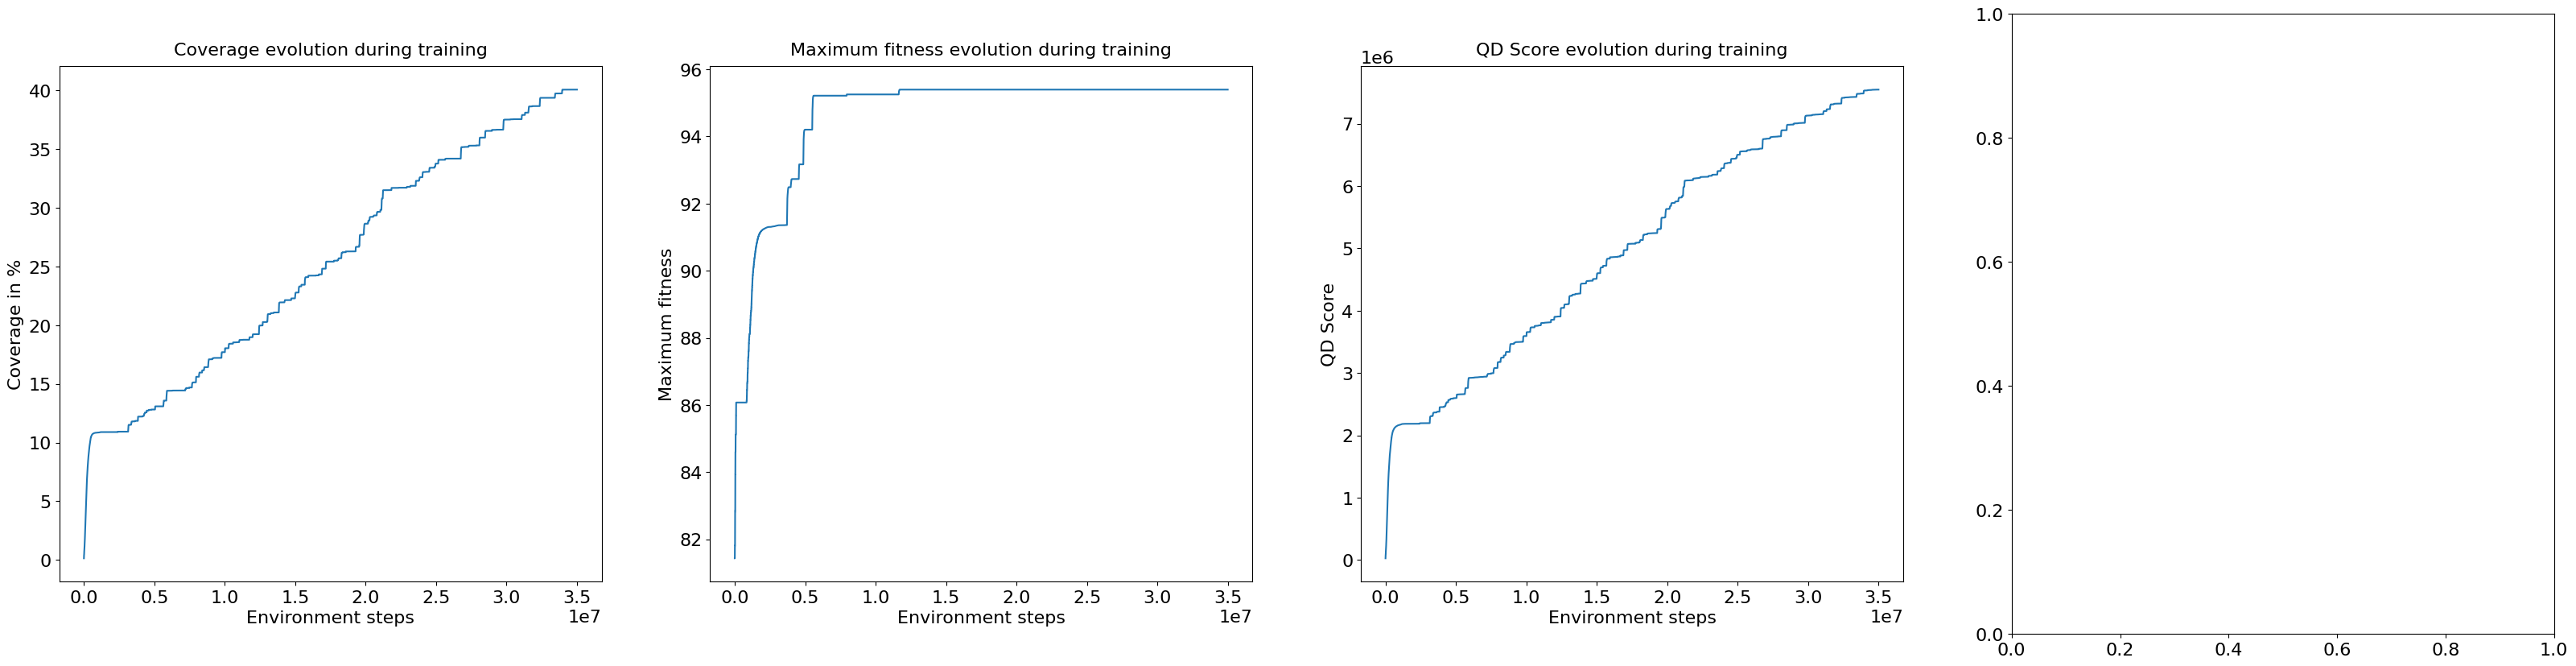

In [119]:
env_steps = jnp.arange(num_iterations) * batch_size

fig, axes = plot_map_elites_results(
    env_steps=env_steps, metrics=metrics, repertoire=repertoire, min_bd=min_bd, max_bd=max_bd
)

In [120]:
# fig, axes = plot_multidimensional_map_elites_grid(
#     repertoire=repertoire,
#     minval=jnp.array([min_bd, min_bd]),
#     maxval=jnp.array([max_bd, max_bd]),
#     grid_shape=grid_shape,
# )